Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



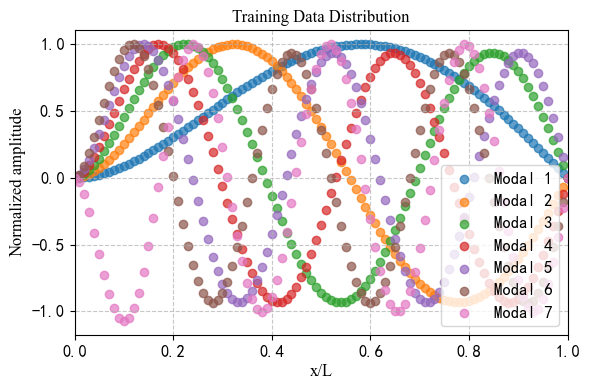

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 64)           128         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           4160        ['dense[0][0]']                  
                                                                                                  
 tf_op_layer_strided_slice_1 (T  [(None, 1)]         0           ['input_1[0][0]']                
 ensorFlowOpLayer)                                                                            

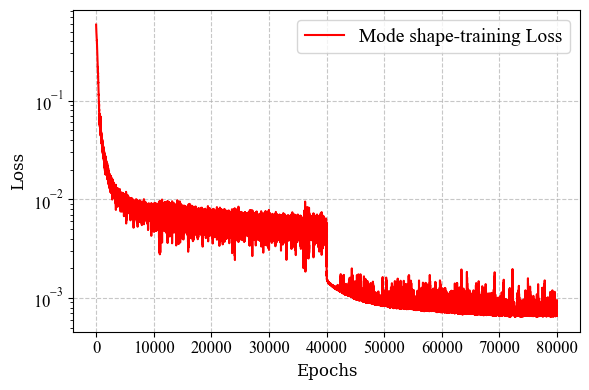

C:\Users\15984\anaconda3\envs\tf2.9\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


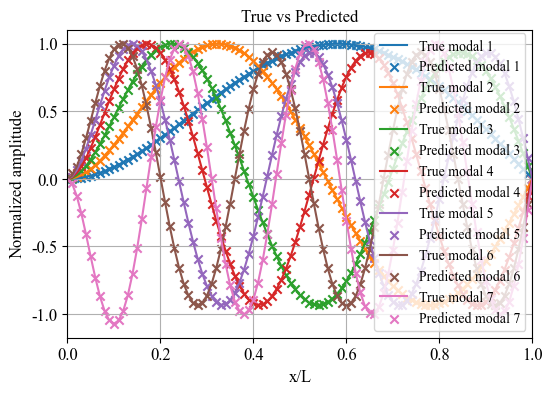

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from sympy import integrate, exp, sin, log, oo, pi,symbols
import deepxde as dde
import scipy.io as scio
from mpl_toolkits.mplot3d import Axes3D
from deepxde.backend import tf
import datetime
import os
from pylab import mpl
from scipy.signal import chirp, spectrogram
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
from matplotlib.pyplot import MultipleLocator
import re
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from math import sqrt, pi

from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LambdaCallback


# 自定义正弦激活函数
def sin_activation(x):
    return tf.math.sin(x)

# 注册自定义激活函数
get_custom_objects().update({'sin': Activation(sin_activation)})

# 加载数据
# 假设文件路径为 'data.txt'

data_pre = np.loadtxt('SHULIU MODAL.txt')  # 假设文件名为 data.txt
X_pre = data_pre[:, 0].reshape(-1, 1)  # 第一列为输入特征，调整形状为二维
y_pre = data_pre[:, 1:8]               # 后 10 列为输出标签

y_pre = y_pre / np.max(y_pre, axis=0)

font = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}


plt.figure(figsize=(6,4))
for i in range(y_pre.shape[1]):
    plt.scatter(X_pre, y_pre[:, i], label=f'Modal {i+1}', alpha=0.7)

plt.title("Training Data Distribution",fontdict=font)
plt.xlabel("x/L",fontdict=font)
plt.ylabel("Normalized amplitude",fontdict=font)
plt.xlim([0,1])
plt.legend(loc='lower right', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  # 更加淡化的网格
plt.savefig('modal_train data.png', dpi=300)  # 设置分辨率为1200
plt.show()


# 定义网络的超参数
w_nodenum_pre =64 # 每一层的神经元数
w_layer_pre = 3   # 隐藏层的数量
activation_func_pre = "tanh"  # 隐藏层使用的激活函数

# 定义 modify_output 函数：应用于模型的输出

# def modify_output_pre(X):
#     ww = []
#     for i in range(5):  # Create 5 sub-networks
#         ww_subnetwork = tf.keras.layers.Dense(w_nodenum_pre, activation=activation_func_pre)(X)
#         for _ in range(w_layer_pre):  # Each sub-network has multiple layers
#             ww_subnetwork = tf.keras.layers.Dense(w_nodenum_pre, activation=activation_func_pre)(ww_subnetwork)
#         ww_subnetwork = X[:, 0:1] * X[:, 1:2] * (X[:, 1:2] - 3) * (X[:, 0:1] - 3) * tf.keras.layers.Dense(1, activation=None)(ww_subnetwork)  # Last layer scaling
#         ww.append(ww_subnetwork)  # Add the output of each sub-network to the list
#     ww = tf.concat(ww, axis=1)  # Concatenate all sub-network outputs along axis 1
#     return ww

def modify_output_pre(X):
    ww = tf.keras.layers.Dense(w_nodenum_pre, activation=activation_func_pre)(X)
    for i in range(w_layer_pre):  
        ww = tf.keras.layers.Dense(w_nodenum_pre, activation=activation_func_pre)(ww)
    ww = X[:, 0:1]* (X[:, 0:1]-1) * tf.keras.layers.Dense(7, activation=None)(ww)
    return ww
# 创建模型的输入层，假设输入维度是 2
inputs_pre = tf.keras.Input(shape=(1,))
output_pre = modify_output_pre(inputs_pre)

# 创建模型
pre_model = tf.keras.Model(inputs=inputs_pre, outputs=output_pre)

# 查看模型概况
pre_model.summary()

# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch <40000:
        return 0.001  # First 5000 epochs
    else:
        return 0.0001 # Next 5000 epochs

# Create the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

tf.compat.v1.disable_eager_execution()


history1 = pre_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mae',  # 使用 Mean Absolute Error
    metrics=['accuracy']
)

# 自定义回调函数，每 1000 个 epoch 打印一次损失
def on_epoch_end(epoch, logs):
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch + 1}, Loss: {logs['loss']:.4f}")

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
history1 = pre_model.fit(
    X_pre, y_pre,
    epochs= 80000,  # 训练 60000 个 epoch
    batch_size=2048,  # 可根据需要调整批量大小
    callbacks=[print_callback, lr_scheduler],  # 包含自定义回调和学习率调度
    verbose=0  # 静默模式
)

# 冻结层，
#for layer in model.layers[:3]:
for layer in pre_model.layers:
    layer.trainable = False

# 创建图形
plt.figure(figsize=(6, 4))
plt.rcParams['font.family'] = 'Times New Roman'
# 绘制训练损失曲线
plt.plot(history1.history['loss'], label='Mode shape-training Loss', color='red', linestyle='-')
# 设置对数坐标
plt.yscale('log')
# 设置标题和标签
plt.title('', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.xlabel('Epochs', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.ylabel('Loss', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
# 显示图例
plt.legend(fontsize=14)
# 设置坐标轴刻度标签的字体大小
plt.tick_params(axis='both', which='major', labelsize=12)
# 布局调整
plt.tight_layout()
# 添加网格
plt.grid(True, linestyle='--', alpha=0.7)
# 保存图片
plt.savefig('modal_train.png', dpi=300)
# 显示图表
plt.show()
    
# 预测训练集
y_train_pred = pre_model.predict(X_pre)

# 绘制真实值（实线）与预测值（点）对比图
plt.figure(figsize=(6,4))
plt.rcParams['font.family'] = 'Times New Roman'
for i in range(y_pre.shape[1]):
    plt.plot(X_pre, y_pre[:, i], label=f'True modal {i+1}', alpha=1)  # 用实线绘制真实值
    plt.scatter(X_pre, y_train_pred[:, i], label=f'Predicted modal {i+1}', alpha=1, marker='x')  # 用点绘制预测值
plt.title("True vs Predicted", fontdict=font)
plt.xlabel("x/L", fontdict=font)
plt.ylabel("Normalized amplitude", fontdict=font)
plt.xlim(0, 1)
plt.xticks(fontsize=12)  # 设置x轴刻度字体大小
plt.yticks(fontsize=12)  # 设置y轴刻度字体大小
plt.legend(loc='lower right', fontsize=10)  #
plt.grid(True)
plt.savefig('modal_pre.png', dpi=300)  #
plt.show()

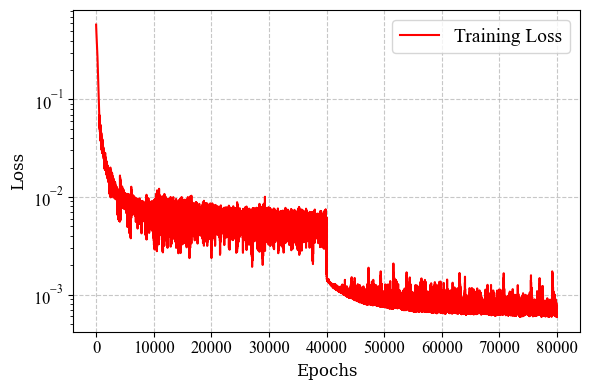

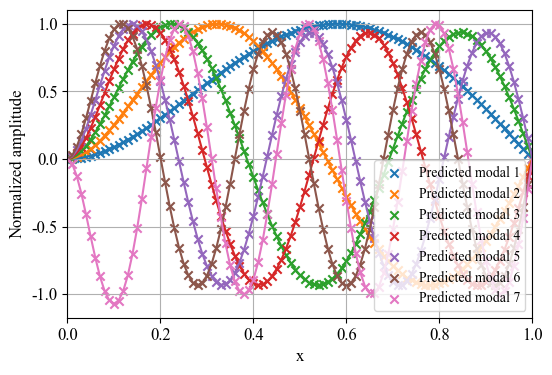

In [2]:
# 创建图形
plt.figure(figsize=(6, 4))
plt.rcParams['font.family'] = 'Times New Roman'
# 绘制训练损失曲线
plt.plot(history1.history['loss'], label='Training Loss', color='red', linestyle='-')
# 设置对数坐标
plt.yscale('log')
# 设置标题和标签
plt.title('', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.xlabel('Epochs', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
plt.ylabel('Loss', fontdict={'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12})
# 显示图例
plt.legend(fontsize=14)
# 设置坐标轴刻度标签的字体大小
plt.tick_params(axis='both', which='major', labelsize=12)
# 布局调整
plt.tight_layout()
# 添加网格
plt.grid(True, linestyle='--', alpha=0.7)
# 保存图片
plt.savefig('modal_train.png', dpi=300)
# 显示图表
plt.show()
    
# 预测训练集
y_train_pred = pre_model.predict(X_pre)

# 绘制真实值（实线）与预测值（点）对比图
plt.figure(figsize=(6,4))
plt.rcParams['font.family'] = 'Times New Roman'
for i in range(y_pre.shape[1]):
    plt.plot(X_pre, y_pre[:, i], label='', alpha=1)  # 用实线绘制真实值
    plt.scatter(X_pre, y_train_pred[:, i], label=f'Predicted modal {i+1}', alpha=1, marker='x')  # 用点绘制预测值
plt.title("", fontdict=font)
plt.xlabel("x", fontdict=font)
plt.ylabel("Normalized amplitude", fontdict=font)
plt.xlim(0, 1)
plt.xticks(fontsize=12)  # 设置x轴刻度字体大小
plt.yticks(fontsize=12)  # 设置y轴刻度字体大小
plt.legend(loc='lower right', fontsize=10)  #
plt.grid(True)
plt.savefig('modal_pre.png', dpi=300)  #
plt.show()

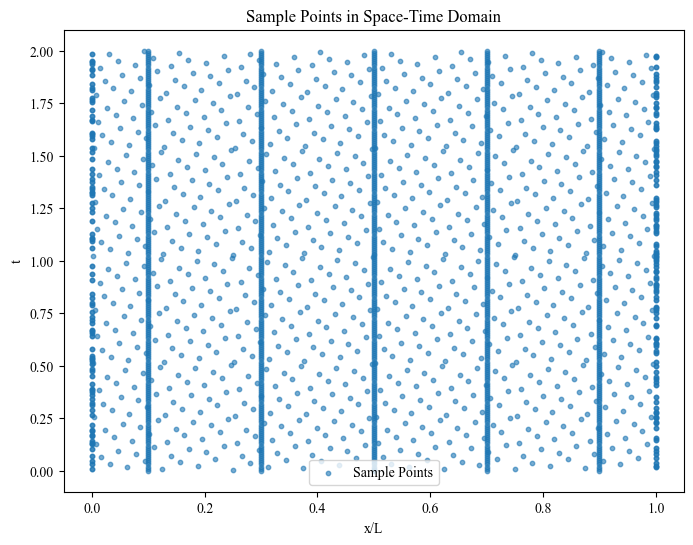

Compiling model...
Building feed-forward neural network...
output shape before return: (None, 1)
'build' took 0.098464 s



C:\Users\15984\anaconda3\envs\tf2.9\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
C:\Users\15984\anaconda3\envs\tf2.9\lib\site-packages\keras\legacy_tf_layers\core.py:261: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
C:\Users\15984\AppData\Local\Temp\ipykernel_36468\788289179.py:135: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w = tf.layers.dense(t, w_nodenum, activation_func)
C:\Users\15984\AppData\Local\Temp\ipykernel_36468\788289179.py:137: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  w = tf.layers.dense(w, w_nodenum, activation_func)

'compile' took 12.365699 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.13e-01, 6.17e-01, 0.00e+00, 1.41e-02]    [7.13e-01, 6.17e-01, 0.00e+00, 1.41e-02]    []  
1000      [1.16e-01, 2.10e-01, 1.64e-02, 3.06e-02]    [1.16e-01, 2.10e-01, 1.64e-02, 3.06e-02]    []  
2000      [5.66e-02, 1.27e-01, 5.21e-03, 1.86e-02]    [5.66e-02, 1.27e-01, 5.21e-03, 1.86e-02]    []  
3000      [2.51e-02, 1.09e-01, 1.88e-03, 6.88e-03]    [2.51e-02, 1.09e-01, 1.88e-03, 6.88e-03]    []  
4000      [2.15e-02, 1.22e-01, 3.99e-04, 5.51e-03]    [2.15e-02, 1.22e-01, 3.99e-04, 5.51e-03]    []  
5000      [1.19e-02, 2.65e-02, 2.77e-04, 7.88e-04]    [1.19e-02, 2.65e-02, 2.77e-04, 7.88e-04]    []  
6000      [1.30e-02, 1.82e-02, 3.17e-04, 3.17e-03]    [1.30e-02, 1.82e-02, 3.17e-04, 3.17e-03]    []  
7000      [8.27e-03, 2.92e-02, 5.76e-04, 4.47e-03]    [8.27e-03, 2.92e-02, 5.76e-04, 4.47e-03]    []  
8000      [1.04e-02

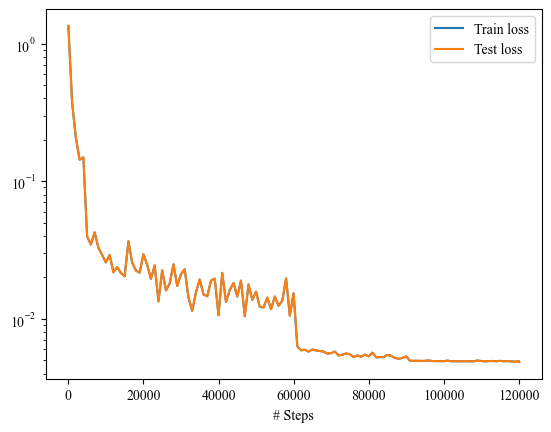

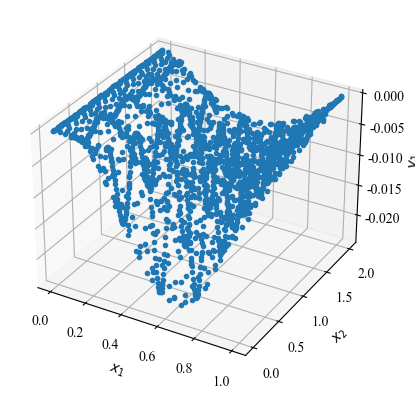

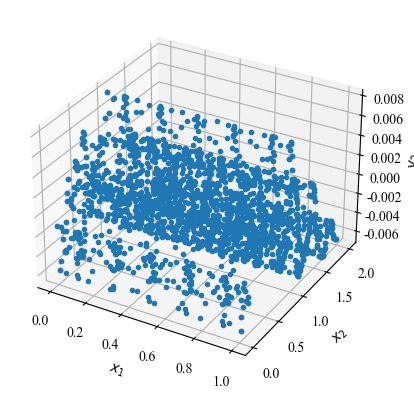

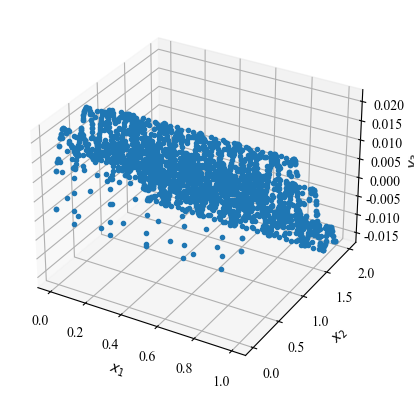

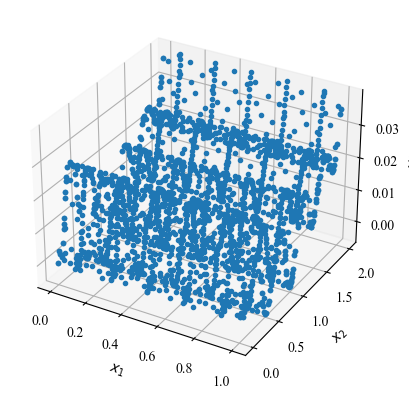

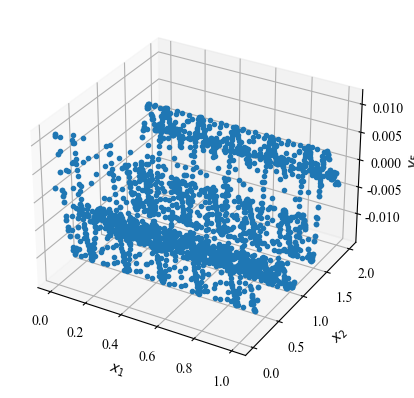

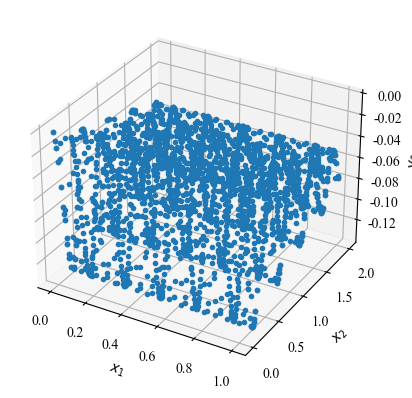

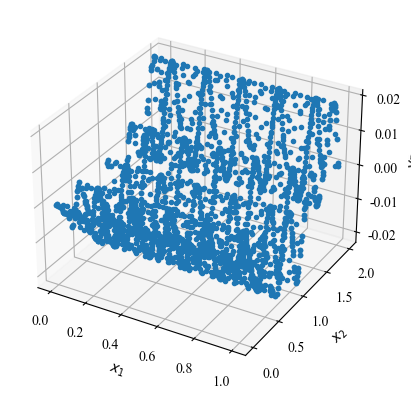

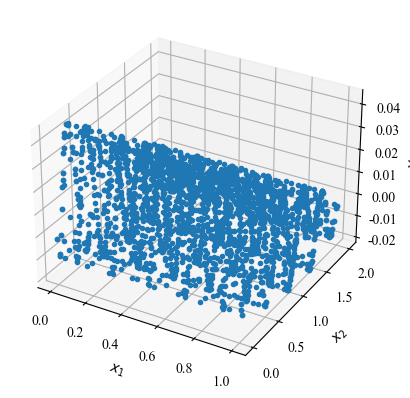

INFO:tensorflow:data/pinn-best_model-120126.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'data/pinn-best_model-120126.ckpt'

In [2]:
#————————————————————— 参数计算 ———————————————————————#
c_s = 2
L = 3.81
U_sg = 1.39  # 气体表观质量
U_sl = 0.29
U_in = U_sg + U_sl
T = 3.27
w = 2 * np.pi / T
k = w/U_in

ro_l = 1000
ro_g = 1.29
ro_s = 926
ro_inb = (ro_l - ro_g) / 8
ro_inj = (U_sg * ro_g + U_sl * ro_l) / (U_sg + U_sl)
g = 9.8

D = 0.063  # 外径
d = 0.063 - 0.0116  # 内径
A_in = np.pi * d ** 2 / 4
A_s = np.pi * (D ** 2 - d ** 2) / 4
# I = np.pi * (D ** 4 - d ** 4) / 64
# E = 7.5e8
beta = (A_in * ro_inj) / (A_s * ro_s)
ke = ro_inb / ro_inj
k_1 = k * L
sigma = pi

#————————————————————— 数据处理 ———————————————————————#
def generate_labeled_data():
    data_w = loadmat("FSIIN_CL.mat")
    t_data = data_w["T_L"].flatten()[:, None]  # 3001*1
    x_data = data_w["X_L"].flatten()  # 101*1
    y_data = data_w["Y_L"]  # 3001*101
    # 根据指定的时间范围 
    valid_indices = (t_data >= 0) & (t_data <=2)
    t_data_filtered = t_data[valid_indices]
    y_data_filtered = y_data[valid_indices.flatten(), :]  # 保留所有空间位置的过滤时间步
    # 选择均匀的11个空间点的索引
    num_space_points =5
    space_indices = np.linspace(10, 90, num_space_points, dtype=int)  # 获取 11 个均匀间隔的空间点索引
    # 根据这些索引选择空间点对应的 `x_data` 值
    
    x_data_filtered = x_data[space_indices]  # 选择对应空间位置的数据
    # 根据这些空间点索引选择 `y_data` 对应的列
    y_data_filtered_space = y_data_filtered[:, space_indices]  # 获取在这些空间点上对应的 `y_data`
    
    # 根据选择的均匀空间点生成对应的 `X` 和 `T` 网格
    X, T = np.meshgrid(x_data_filtered, t_data_filtered.flatten())
    # 构造输入
    inputs = np.hstack([X.flatten()[:, None], T.flatten()[:, None]])
    # 输出数据（标签）
    outputs = y_data_filtered_space.flatten()[:, None]

    return inputs, outputs



#————————————————————— 损失函数定义 ———————————————————————#
xt_data, y_data = generate_labeled_data()

observe_y1 = dde.icbc.PointSetBC(xt_data, y_data, component=0)  #标签数据

geom = dde.geometry.Interval(0, 1) #空间域
timedomain = dde.geometry.TimeDomain(0, 2) #时间域
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def dw_x(X, Y):
    return dde.grad.jacobian(Y, X, i=0, j=0)
def dw_xx(X, Y):
    return dde.grad.hessian(Y, X, component=0, i=0, j=0)
def boundary_x1(X, on_boundary):
    return on_boundary and np.isclose(X[0], 0) 
def boundary_x2(X, on_boundary):
    return on_boundary and np.isclose(X[0], 1) 
def func1(X,Y):
    return  Y[:, 0:1] 
    
bc_1 = dde.icbc.OperatorBC(geomtime, lambda X, Y,_: dw_x(X, Y), boundary_x1)
bc_2 = dde.icbc.OperatorBC(geomtime, lambda X, Y,_: dw_xx(X, Y), boundary_x2)
bc_3 = dde.icbc.OperatorBC(geomtime, lambda X,Y, _: func1(X,Y), boundary_x1)
bc_4 = dde.icbc.OperatorBC(geomtime, lambda X,Y, _: func1(X,Y), boundary_x2)


def FIV(X, Y):   
    dy_dt = dde.grad.jacobian(Y, X, i=0, j=1)
    dy_dtt = dde.grad.hessian(Y, X, component=0, i=1, j=1)
    dy_dxdt=dde.grad.hessian(Y, X, component=0, i=0, j=1)
    dy_dxx=dde.grad.hessian(Y, X, component=0, i=0, j=0)
    dy_dxxxx=dde.grad.hessian(dy_dxx, X, i=0, j=0)
    x = X[:, 0:1]
    t = X[:, 1:2]
    omega = tf.sqrt(EI*100/ (A_s * ro_s * L ** 4))
    c_1 = c_s * L ** 2 / tf.sqrt(A_s * ro_s * EI*100)
    w_1 = w / omega
    u = U_in / (L * omega)
    g_1 = g / (L * omega ** 2)
    
    residual_phy = (
            dy_dtt + c_1 * dy_dt +
            beta * (1 + ke * tf.cos(k_1 * x - w_1 * t + sigma)) * (dy_dtt + 2 * u * dy_dxdt + u ** 2 * dy_dxx) +
            (1 + beta * (1 + ke * tf.cos(k_1 * x - w_1 * t + sigma))) * g_1 +
            dy_dxxxx
    )
    return residual_phy

data = dde.data.TimePDE(geomtime,
                        FIV, 
                        [observe_y1, bc_1, bc_2],  # 使用 PointSetBC
                        num_domain=1000,
                        #anchors=xt_data)
                        num_boundary=200)
train_points = data.train_x

# 绘制采样点
plt.figure(figsize=(8, 6))
plt.scatter(train_points[:, 0], train_points[:, 1], s=10, alpha=0.6, label="Sample Points")
plt.xlabel("x/L")
plt.ylabel("t")
plt.title("Sample Points in Space-Time Domain")
plt.legend()
plt.show()

#————————————————————— 网络架构 ———————————————————————#
EI = dde.Variable(1.0)
net = dde.maps.FNN([2] + [1], None, "Glorot uniform")    #基础架构
w_nodenum = 64
w_layer = 3
activation_func = "tanh"

def modify_output(X, Y):   #修正架构
    x = X[:,0:1]
    t = X[:,1:2]
    y1 = tf.zeros_like(x)  # 创建与 x 形状相同的零张量
    w = tf.layers.dense(t, w_nodenum, activation_func)
    for i in range(w_layer):
        w = tf.layers.dense(w, w_nodenum, activation_func)
    w = 0.1*tf.layers.dense(w, 7, None)*X[:, 1:2]
    
    FAI= pre_model(x)
    for i in range(1, 8):
        wi_term = w[:, (i - 1):i]
        FAIi_term=FAI[:, (i - 1):i]
        y1 += wi_term * FAIi_term  # 逐项累加 
    print(f"output shape before return: {y1.shape}")
    return tf.concat([y1, w], axis=1)  
net.apply_output_transform(modify_output)
model = dde.Model(data, net)
#————————————————————— 训练定义 ———————————————————————

epochs=10000
#variable = dde.callbacks.VariableValue(D, period=1000, filename="variables.dat")


model.compile("adam",
              lr=1e-3,
              loss=["MAE","MAE","MAE","MAE"],
              loss_weights=[1e-1,1e2,1,1], 
              external_trainable_variables=[EI])
variable = dde.callbacks.VariableValue([EI], period=1000, filename="EI-variables1.dat", precision=4)


loss_history, train_state = model.train(iterations=6*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True,
                                        callbacks=[variable])

model.compile("adam",
              lr=1e-4,
              loss=["MAE","MAE","MAE","MAE"],
              loss_weights=[1e-1,1e2,1,1], 
              external_trainable_variables=[EI])
variable = dde.callbacks.VariableValue([EI], period=1000, filename="EI-variables2.dat", precision=4)


loss_history, train_state = model.train(iterations=3*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True,
                                        callbacks=[variable])
model.compile("adam",
              lr=1e-5,
              loss=["MAE","MAE","MAE","MAE"],
              loss_weights=[1e-1,1e2,1,1], 
              external_trainable_variables=[EI])
variable = dde.callbacks.VariableValue([EI], period=1000, filename="EI-variables3.dat", precision=4)


loss_history, train_state = model.train(iterations=3*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True,
                                        callbacks=[variable])
model.compile("L-BFGS",
              loss=["MAE","MAE","MAE","MAE"],
              loss_weights=[1e-1,1e2,1,1], 
              external_trainable_variables=[EI])
variable = dde.callbacks.VariableValue([EI], period=1000, filename="EI-variables4.dat", precision=4)


loss_history, train_state = model.train(iterations=3*epochs, 
                                        display_every=1000, 
                                        disregard_previous_best=True,
                                        callbacks=[variable])

dde.saveplot(loss_history, train_state, issave=True, isplot=True)

model.save('data/pinn-best_model', protocol='backend', verbose=0)

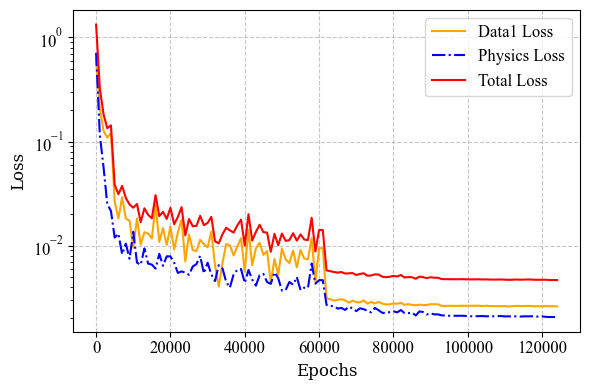

In [3]:
# 假设 train_loss 包含每个 epoch 的 7 个损失值
train_loss = loss_history.loss_train

# 提取每个 epoch 的第一个损失值（假设是物理损失）和第二个损失值（假设是数据损失）
physics_losses = [loss[0] for loss in train_loss]
data1_losses = [loss[1] for loss in train_loss]
total_losses = [p + d for p, d in zip(physics_losses, data1_losses)]

data2_losses = [loss[2] for loss in train_loss]

epochs = np.arange(len(train_loss)) * 1000  # 假设每个点是 1000 个 epoch

font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}


    # 绘制损失函数
plt.figure(figsize=(6, 4))
# 使用不同的线型和颜色
plt.plot(epochs, data1_losses, label='Data1 Loss', color='orange', linestyle='-')  # 虚线
#plt.plot(epochs, data2_losses, label='Data2 Loss', color='grey', linestyle='--')  # 点线
plt.plot(epochs, physics_losses, label='Physics Loss', color='blue', linestyle='-.')  # 点划线
plt.plot(epochs, total_losses, label='Total Loss', color='red', linestyle='-')  # 点线


plt.yscale('log')  # 将 Y 轴设置为对数坐标
plt.title('', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('Loss', fontdict=font)

plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  # 更加淡化的网格
plt.savefig('model_loss.png', dpi=1200)  # 设置分辨率为1200
plt.show()

输入特征形状: (20301, 2)
输出标签形状: (20301, 1)
(201, 101)


C:\Users\15984\AppData\Local\Temp\ipykernel_36468\3967241628.py:48: RuntimeWarning: invalid value encountered in divide
  R_y_error = abs((y_pre_reshaped - y_true_reshaped)/y_true_reshaped)


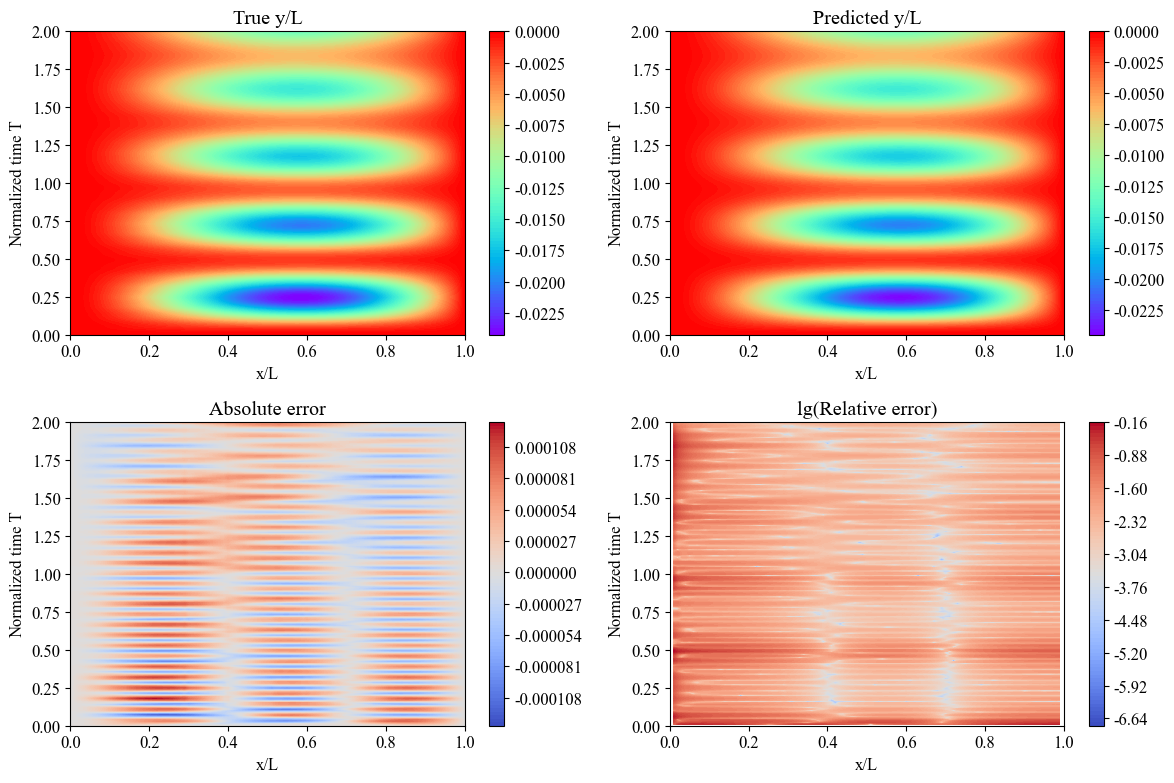

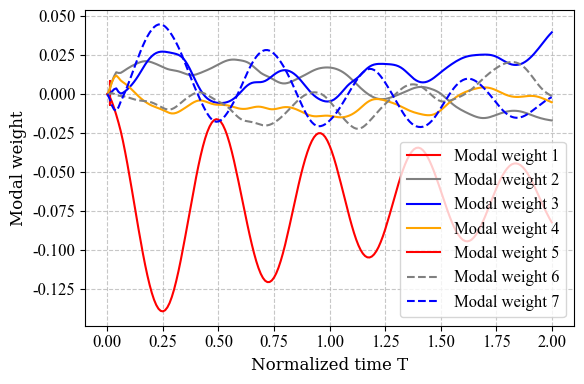

In [4]:
# 进行预测
def generate_labeled_data2():
    data_w = loadmat("FSIIN_CL.mat")
    t_data = data_w["T_L"].flatten()[:, None]  # 3001*1
    x_data = data_w["X_L"].flatten()  # 101*1
    y_data = data_w["Y_L"]  # 3001*101

    # 根据指定的时间范围 (0 <= t <= 25) 过滤 `t_data` 和 `y_data`
    valid_indices = (t_data >= 0) & (t_data <= 2)
    t_data_filtered = t_data[valid_indices]
    y_data_filtered = y_data[valid_indices.flatten(), :]  # 保留所有空间位置的过滤时间步

    X, T = np.meshgrid(x_data, t_data_filtered.flatten())

    inputs = np.hstack([X.flatten()[:, None], T.flatten()[:, None]])
    # 输出数据（标签）
    outputs = y_data_filtered.flatten()[:, None]

    # 输出输入和输出的形状
    print("输入特征形状:", inputs.shape)  # 应为 (N, 2)，N 为总样本数
    print("输出标签形状:", outputs.shape)  # 应为 (N, 1)，N 为总样本数
    return inputs, outputs

xt2_data, y2_data = generate_labeled_data2()

predictions = model.predict(xt2_data)
Y_PRE=predictions[:,0:1]
w1=predictions [:,1:2].reshape(-1, 101)
w2=predictions [:,2:3].reshape(-1, 101)
w3=predictions [:,3:4].reshape(-1, 101)
w4=predictions [:,4:5].reshape(-1, 101)
w5=predictions [:,5:6].reshape(-1, 101)
w6=predictions [:,6:7].reshape(-1, 101)
w7=predictions [:,7:8].reshape(-1, 101)



X = xt2_data[:, 0].reshape(-1, 101)  # 假设 x 数据有 101 个样本
T = xt2_data[:, 1].reshape(-1, 101)  # 对应的 t 数据
print(X.shape)
y_true_reshaped= y2_data.reshape(-1, 101)
y_pre_reshaped = Y_PRE.reshape(-1, 101)


# 计算误差
y_error = y_pre_reshaped - y_true_reshaped

R_y_error = abs((y_pre_reshaped - y_true_reshaped)/y_true_reshaped)


plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12  # 设定字体大小为14
# 创建子图
plt.figure(figsize=(12, 8))

# 绘制预测结果的热图
plt.subplot(2, 2, 1)
plt.contourf(X, T, y_true_reshaped, levels=100, cmap='rainbow')
plt.colorbar(label='')
plt.xlabel('x/L')
plt.ylabel('Normalized time T')
plt.title('True y/L')

plt.subplot(2, 2, 2)
plt.contourf(X, T, y_pre_reshaped, levels=100, cmap='rainbow')
plt.colorbar(label='')
plt.xlabel('x/L')
plt.ylabel('Normalized time T')
plt.title('Predicted y/L')


# 绘制误差分布的热图
plt.subplot(2, 2, 3)
plt.contourf(X, T, y_error, levels=100, cmap='coolwarm')
plt.colorbar(label='')
plt.xlabel('x/L')
plt.ylabel('Normalized time T')
plt.title('Absolute error')

log_R_y_error = np.log10(R_y_error) 
# 绘制误差分布的热图
plt.subplot(2, 2, 4)
plt.contourf(X, T, log_R_y_error, levels=100, cmap='coolwarm')
plt.colorbar(label='')
plt.xlim(0, 1)  # 
plt.ylim(0, 2)  # 
plt.xlabel('x/L')
plt.ylabel('Normalized time T')
plt.title('lg(Relative error)')
plt.tight_layout()
plt.savefig("响应预测.png", dpi=300)
plt.show()



plt.figure(figsize=(6, 4))
# 使用不同的线型和颜色

plt.plot(X[:,1:2].flatten(), w1[:,1:2].flatten(), label='Modal weight 1', color='red', linestyle='-')  # 点线


plt.plot(T[:,1:2].flatten(), w2[:,1:2].flatten(), label='Modal weight 2', color='grey', linestyle='-')  # 点线
plt.plot(T[:,1:2].flatten(), w3[:,1:2].flatten(), label='Modal weight 3', color='blue', linestyle='-')  # 点线
plt.plot(T[:,1:2].flatten(), w4[:,1:2].flatten(), label='Modal weight 4', color='orange', linestyle='-')  # 点线
plt.plot(T[:,1:2].flatten(), w5[:,1:2].flatten(), label='Modal weight 5', color='red', linestyle='-')  # 点线
plt.plot(T[:,1:2].flatten(), w6[:,1:2].flatten(), label='Modal weight 6', color='grey', linestyle='--')  # 点线
plt.plot(T[:,1:2].flatten(), w7[:,1:2].flatten(), label='Modal weight 7', color='blue', linestyle='--')  # 点线

plt.title('', fontdict=font)
plt.xlabel('Normalized time T', fontdict=font)
plt.ylabel('Modal weight', fontdict=font)


plt.legend(fontsize=12,loc='lower right' )


plt.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)  # 更加淡化的网格
plt.savefig("模态权重.png", dpi=300)
plt.show()




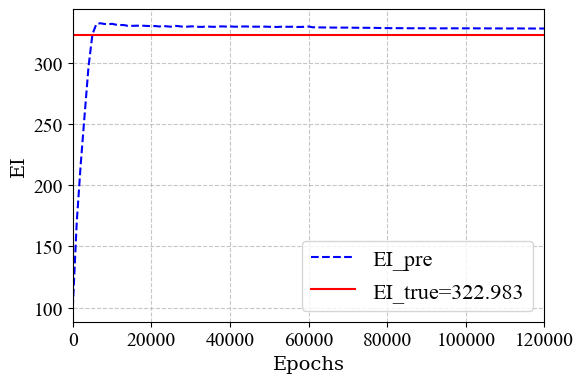

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def scientific(x, pos):
    return f'{x:.2e}'  # 转换为科学计数法
# 定义文件路径
file_paths = [
    'EI-variables1.dat',
    'EI-variables2.dat',
    'EI-variables3.dat',  
    'EI-variables4.dat'
   
]

# 读取并合并数据
data_frames = []
for i, file_path in enumerate(file_paths):
    # 读取文件并去除方括号
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, names=['Index', 'Value'])
    df['Value'] = df['Value'].str.strip("[]").astype(float)  # 去掉方括号并转换为浮点数
    
    # 去除 El-variables2.dat、El-variables3.dat 和 El-variables4.dat 的第一行
    if i in [1, 2, 3]:  # 第2、第3和第4个文件
        df = df.iloc[1:]  # 去除第一行
    
    data_frames.append(df)

# 合并所有文件的数据
merged_data = pd.concat(data_frames, ignore_index=True)

font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 14}


    
    # 绘制损失函数
plt.figure(figsize=(6, 4))
# 使用不同的线型和颜色
plt.plot(merged_data['Index'], merged_data['Value']*100, label='EI_pre', color='blue',linestyle='--')
plt.axhline(y=322.983, label='EI_true=322.983', color='red', linestyle='-')  # 添加水平线

plt.xlim(0,120000)  # 将 X 轴限制在 0 到 20000 之间
plt.title('', fontdict=font)
plt.xlabel('Epochs', fontdict=font)
plt.ylabel('EI', fontdict=font)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.legend(fontsize=16,loc='lower right')  # 将图例位置设置为右上角
plt.grid(True, linestyle='--', alpha=0.7)  # 更加淡化的网格
plt.tight_layout()
plt.savefig("EI.png", dpi=300)
plt.show()